This model shows us when and where severe crashes are most likely to happen. With this, we can focus patrols, alerts, and safety measures exactly where they matter most. It helps us shift from reacting to crashes to preventing them

In [31]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import RocCurveDisplay

In [11]:
df = pd.read_csv("../data/processed/accidents.csv")


## Feature Preparation

In [20]:
df["is_severe"] = (df["severity"] == 4).astype(int)

df["start_time"] = pd.to_datetime(df["start_time"], errors="coerce")
df["end_time"]   = pd.to_datetime(df["end_time"], errors="coerce")

df["hour"] = df["start_time"].dt.hour
df["dayofweek"] = df["start_time"].dt.dayofweek
df["month"] = df["start_time"].dt.month

df["has_precip"] = (df["precipitationin"] > 0).astype(int)
df["low_visibility"] = (df["visibilitymi"] < 3).astype(int)

numeric_features = [
    "distancemi",
    "min_temperature_f",
    "humidity",
    "pressurein",
    "visibilitymi",
    "wind_speedmph",
    "precipitationin",
    "hour",
    "dayofweek",
    "month"
]
numeric_features = [c for c in numeric_features if c in df.columns]

categorical_features = [
    "state",
    "city",
    "wind_direction",
    "weather_condition",
    "sunrise_sunset",
    "civil_twilight"
]
categorical_features = [c for c in categorical_features if c in df.columns]

X = df[numeric_features + categorical_features]
y = df["is_severe"]

## Train/Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

## Transformers

In [ ]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    [
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Modeling

In [ ]:
clf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

clf.fit(X_train, y_train)

## Evaluation

<Figure size 600x600 with 0 Axes>

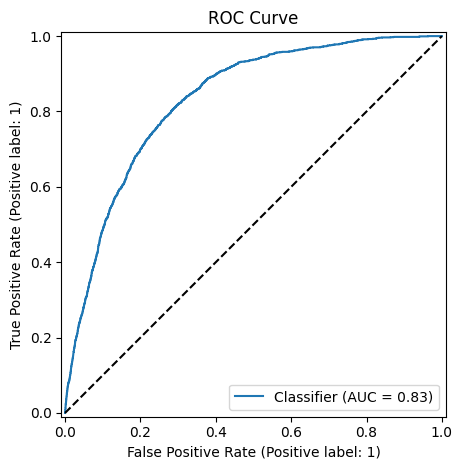

In [30]:

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve")
plt.plot([0,1],[0,1], 'k--')
plt.tight_layout()
plt.show()


In [22]:
pred = clf.predict(X_test)
proba = clf.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred))


ROC AUC: 0.8317717147841182
              precision    recall  f1-score   support

           0       0.99      0.72      0.83     47915
           1       0.08      0.80      0.14      1412

    accuracy                           0.72     49327
   macro avg       0.53      0.76      0.49     49327
weighted avg       0.97      0.72      0.81     49327



## Features Importance

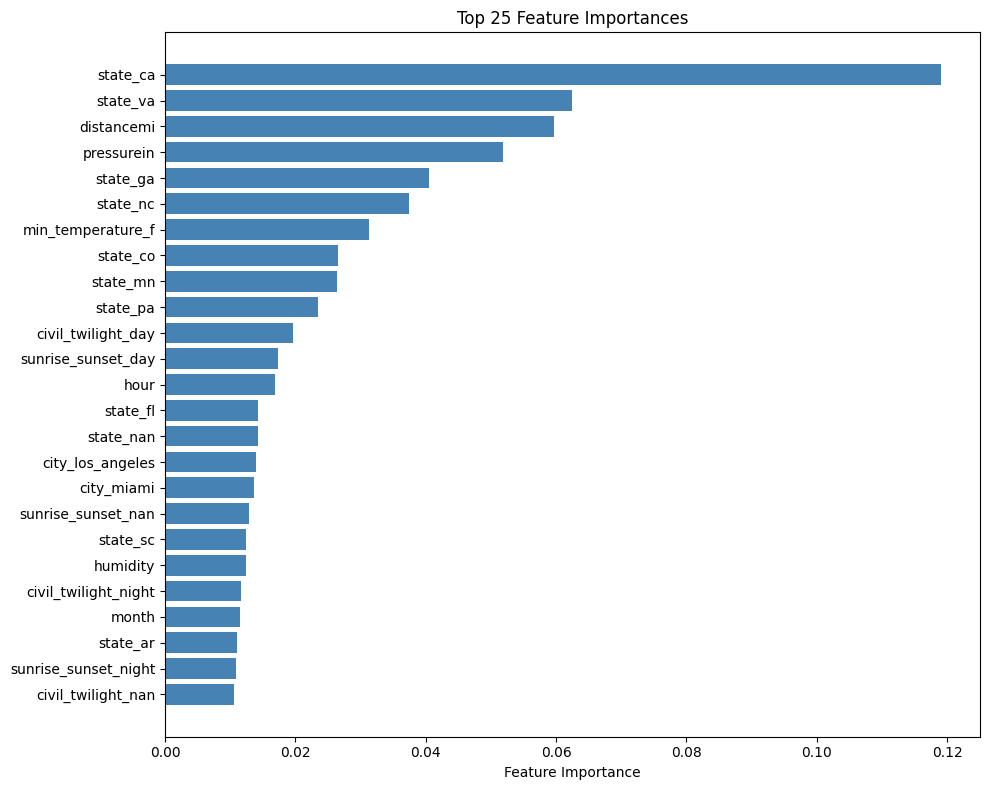

In [28]:
rf = clf.named_steps["model"]

num_features_out = numeric_features

cat_encoder = clf.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
cat_features_out = list(cat_encoder.get_feature_names_out(categorical_features))

all_features = num_features_out + cat_features_out

importances = rf.feature_importances_

idx = np.argsort(importances)[::-1] 
top_n = 25 

plt.figure(figsize=(10,8))
plt.barh(
    np.array(all_features)[idx][:top_n][::-1],
    importances[idx][:top_n][::-1],
    color="steelblue"
)
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Feature Importances")
plt.tight_layout()
plt.show()
